In [50]:
import seaborn as sns
sns.set()

In [105]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [2]:
DIR = '../../data/processed'
crawls = glob.glob('{}/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [6]:
df = df[['true_perc', 'false_perc', 'mixed_perc', 'invalid_count', 'known_count', 'total_count', 'label']][df.label!='mixture']

In [21]:
X = df.drop(['label'], axis=1).astype(float)
y = df.label.apply(lambda x: True if x=='true' else False).ravel()

In [8]:
X.shape

(969, 6)

In [9]:
y.shape

(969,)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [26]:
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

In [101]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'clf__n_estimators': n_estimators,
               'clf__max_features': max_features,
               'clf__max_depth': max_depth,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf,
               'clf__bootstrap': bootstrap}

In [136]:
import scipy.stats as st

sm = SMOTE(ratio = 'auto', k_neighbors = 5, n_jobs = -1)
smote_enn = SMOTEENN(smote = sm)


# param_fixed= {'n_jobs': -1}
# clf = RandomForestClassifier(**param_fixed)
# #Parameter distribution for RandomizedSearchCV
# param_dist = {
#         'smote_enn__smote__k_neighbors': [1,2,3,4,5,10],
    
#         'clf__max_depth': [1,2,3,4,5],

#         'clf__n_estimators': [10,20,30,40,50],

#         'clf__min_samples_split': [2,4,5,6,3],

#         'clf__max_features': [1,2,3,4,5,6],

#         'clf__min_weight_fraction_leaf': st.uniform(0., 0.5)}

clf = SVC()
# SVC
parameters = {
    #'smote_enn__smote__k_neighbors': [1,2,3,4,5,10],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'], 
              'clf__C': [0.001, 0.01, 0.1, 0.25,0.5,0.75, 1,10, 25, 50, 100, 1000],
              'clf__gamma': [0.0001,0.001,0.01,0.1,1,2,3,'auto','scale'],
             'clf__class_weight': ['balanced'],
             'clf__probability': [True]}



steps = [('scaler', MaxAbsScaler()),
         #('smote_enn', smote_enn), 
         ('clf', clf)]

pipeline = Pipeline(steps)

rs_clf = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=100, verbose=2,

                            scoring='roc_auc', refit=True,cv=folds, random_state=42)

In [137]:
rs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.5 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.5, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.5 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.5, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.5 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.5, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.5 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.5, total=   0.0s
[CV] clf__probability=True,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.5, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.5 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.5, total=   0.0s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.75 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.75, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.75 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.75, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=0.75 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__

[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=1, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1000, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1000, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1000, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=scale, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=scale, clf__class_we

[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.1, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=0.1, clf__class_weight=balanced, clf__C=0.1 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=0.1, clf__class_weight=balanced, clf__C=0.1, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=0.1, clf__class_weight=balanced, clf__C=0.1 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=0.1, clf__class_weight=balanced, clf__C=0.1, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=0.1, clf__class_weight=balanced, clf__C=0.1 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=0.1, clf__class_weight=balanced, clf__C=0.1, total=   0.0s
[CV] clf__probability=True, clf__kernel=rbf, clf__gamma=auto, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=auto, clf__class_weight=balanced, clf__C=1000, tot

[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=0.01, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=0.01 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=0.01, total=   0.0s
[CV] clf__probability=True, clf__kernel=rbf, clf__gamma=0.01, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=0.01, clf__class_weight=balanced, clf__C=1000, total=   0.1s
[CV] clf__probability=True, clf__kernel=rbf, clf__gamma=0.01, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=0.01, clf__class_weight=balanced, clf__C=1000, total=   0.1s
[CV] clf__probability=True, clf__kernel=rbf, clf__gamma=0.01, clf__class_weight=balanced, clf__C=1000 
[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=0.01, clf__class_weight=balanced, clf__C=1000, total=   0.1

[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=auto, clf__class_weight=balanced, clf__C=0.1, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=auto, clf__class_weight=balanced, clf__C=0.1 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=auto, clf__class_weight=balanced, clf__C=0.1, total=   0.1s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100, total=   0.1s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100, total=   

[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=0.001, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=0.001 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=0.001, total=   0.1s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.001 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.001, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.001 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.001, total=   0.0s
[CV] clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.001 
[CV]  clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=

[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=0.01, total=   0.1s
[CV] clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=0.01 
[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=0.01, total=   0.1s
[CV] clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=0.01 
[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=0.01, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=25 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=25, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=25 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.0001, clf__class_weight=balanced, cl

[CV]  clf__probability=True, clf__kernel=rbf, clf__gamma=auto, clf__class_weight=balanced, clf__C=0.001, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=100, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=100, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=100 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=100, total=   0.1s
[CV] clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=balanced, clf__C=50 
[CV]  clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.001, clf__class_weight=ba

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   54.9s finished
/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', MaxAbsScaler(copy=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'clf__kernel': ['linear', 'rbf', 'sigmoid'], 'clf__C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 25, 50, 100, 1000], 'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 'auto', 'scale'], 'clf__class_weight': ['balanced'], 'clf__probability': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [130]:
best_score = rs_clf.best_score_

best_params = rs_clf.best_params_

print("Best score: {}".format(best_score))

print("Best params: {}".format(best_params))

Best score: 0.6375677499767272
Best params: {'smote_enn__smote__k_neighbors': 10, 'clf__probability': True, 'clf__kernel': 'linear', 'clf__gamma': 0.0001, 'clf__class_weight': 'balanced', 'clf__C': 50}


In [131]:
pred = rs_clf.predict(X_test)
pd.Series(pred).value_counts(normalize=True)

False    0.654321
True     0.345679
dtype: float64

In [132]:
y_pred = rs_clf.predict_proba(X_test)
y_pred = y_pred[:,1]

In [133]:
roc_auc_score(y_test, y_pred)

0.6300773694390714

In [134]:
f1_score(y_test, pred)

0.4172661870503597

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.34')

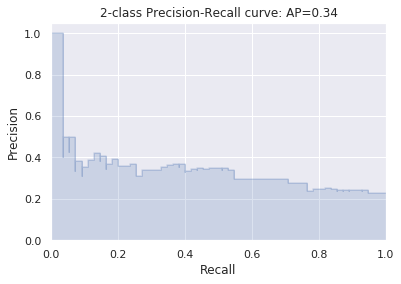

In [135]:
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))